In [8]:
# 10 songs for each of 4 trials for each of 31 subjects = total of 1240 playings
# 12 target classes: HAPPY, LOW VALENCE, LOW TENSION, LOW ENERGY, HIGH ENERGY, SURPRISE, FEAR, TENDER, ANGER, SAD, HIGH VALENCE, HIGH TENSION
# ? Unknown how many playings fall under each target

In [9]:
import mne # package for reading edf data
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, sosfreqz  

from data_tools import * # i made all the functions into a python file

In [10]:
# import pyeeg
# pyeeg.bin_power()

In [11]:
# pd

In [12]:
df = get_recording_events(2,3) # you can now run the functions here
df.head() # gets the head of the dataframe

Extracting EDF parameters from c:\Users\Staro\Documents\GitHub\COGS189-final-project\data\sub-02\eeg\sub-02_task-run3_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Staro\Documents\GitHub\COGS189-final-project\data_tools.py:17: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(file)


time  song_clip         FP1         FP2         F7         F3         Fz  \
0  6703         29 -149.623601 -111.775574  49.314735  -1.279259 -65.707514   
1  6704         29 -173.877896 -116.794177  33.418188  -1.556187 -69.779909   
2  6705         29 -175.805390 -118.389954  64.473467  -7.593208 -69.412832   
3  6706         29 -170.906344 -119.754459  54.479436  -3.910071 -68.782323   
4  6707         29 -162.594027 -116.215997  87.748158 -12.411747 -72.142157   

          F4         F8         T3  ...         T4         T5         P3  \
0 -49.011326 -12.416786  10.371734  ...   9.759761 -35.782211 -16.815982   
1 -51.001599 -13.867926  31.866286  ...  12.467998 -16.045504  -4.362878   
2 -52.480088 -16.696420  13.820617  ...   9.736810  -9.136154   3.951592   
3 -53.006089 -20.090613  -8.301004  ...   4.871165  -7.288654   6.899788   
4 -50.020679 -13.720352  21.206103  ...  10.517150  -4.494874   3.421475   

          Pz         P4         T6          O1        O2  Number  TARGET  
0   8.581891  72.525610  49.671773  102.469989 -2.850259      29   HAPPY  
1  12.894548  76.087524  50.927955  112.681901  2.977428      29   HAPPY  
2  12.663714  72.600796  39.190897  109.743665 -2.839427      29   HAPPY  
3  14.493496  71.651578  32.960740  111.808649 -2.427806      29   HAPPY  
4  13.761583  74.085710  37.845894  114.674970  1.200959      29   HAPPY  

[5 rows x 23 columns]

this is an example of what will be in the labels list

In [13]:
df.groupby('song_clip').head(1).TARGET.to_list()

['HAPPY',
 'FEAR',
 'ANGER',
 'SAD',
 'SURPRISE',
 'HIGH VALENCE',
 'SAD',
 'HIGH VALENCE',
 'SAD',
 'SURPRISE']

This is an example of what will be in the lists (one item in the recordings list). If you wish to keep the time column, remove it from the drop columns list
it actually isnt always 16000 columns, sometimes for whatever reason the last one of 10 cuts off early for reasons unknown.

In [5]:

# df.song_clip.unique()
df[df.song_clip==29].drop(columns=['song_clip','Number','TARGET','time'])

FP1         FP2         F7          F3         Fz         F4  \
0     -149.623601 -111.775574  49.314735   -1.279259 -65.707514 -49.011326   
1     -173.877896 -116.794177  33.418188   -1.556187 -69.779909 -51.001599   
2     -175.805390 -118.389954  64.473467   -7.593208 -69.412832 -52.480088   
3     -170.906344 -119.754459  54.479436   -3.910071 -68.782323 -53.006089   
4     -162.594027 -116.215997  87.748158  -12.411747 -72.142157 -50.020679   
...           ...         ...        ...         ...        ...        ...   
15996 -246.118752  -71.002319 -68.266054  -88.566823  -9.384956  -2.481576   
15997 -243.147199  -67.764510 -65.784314  -91.696104  -7.847552   0.247942   
15998 -236.400971  -61.473912 -61.089132 -105.459403  -3.969492   1.484755   
15999 -238.248153  -61.867074 -58.808614  -96.902342  -4.798654   2.167134   
16000 -241.540954  -63.300961 -58.674466  -86.323710  -7.597076   2.010755   

              F8         T3         C3         Cz         C4         T4  \
0     -12.416786  10.371734 -32.831533 -28.469000 -12.807568   9.759761   
1     -13.867926  31.866286 -24.871664 -25.202006 -11.848305  12.467998   
2     -16.696420  13.820617  -5.290389 -25.539442 -15.896393   9.736810   
3     -20.090613  -8.301004   1.594897 -25.505698 -18.966032   4.871165   
4     -13.720352  21.206103 -17.349589 -25.766444 -14.610981  10.517150   
...          ...        ...        ...        ...        ...        ...   
15996 -35.143119 -33.627648 -80.909136 -21.091422 -37.000165  17.976275   
15997 -32.708155 -32.547695 -83.615492 -22.468774 -38.189650  15.956573   
15998 -28.600690 -30.736161 -84.610475 -21.839916 -37.901871  11.595854   
15999 -27.493888 -31.676765 -80.391745 -20.373604 -39.264024  14.900820   
16000 -23.042085 -36.031415 -75.934219 -20.993259 -40.376768  22.382897   

              T5         P3         Pz         P4         T6          O1  \
0     -35.782211 -16.815982   8.581891  72.525610  49.671773  102.469989   
1     -16.045504  -4.362878  12.894548  76.087524  50.927955  112.681901   
2      -9.136154   3.951592  12.663714  72.600796  39.190897  109.743665   
3      -7.288654   6.899788  14.493496  71.651578  32.960740  111.808649   
4      -4.494874   3.421475  13.761583  74.085710  37.845894  114.674970   
...          ...        ...        ...        ...        ...         ...   
15996 -37.900077 -38.746095   7.382679  61.454542  -5.194215   76.097780   
15997 -39.056642 -39.899332   7.804937  62.206397  -1.501800   74.001975   
15998 -35.586947 -36.662827   7.652924  63.578533  -2.757982   86.124767   
15999 -33.499122 -33.435622  10.715699  64.264601  -2.757982   92.422455   
16000 -25.958919 -29.008679  12.793206  62.337972  -4.953129   92.740935   

              O2  
0      -2.850259  
1       2.977428  
2      -2.839427  
3      -2.427806  
4       1.200959  
...          ...  
15996 -10.216109  
15997  -4.648393  
15998   2.825779  
15999   3.248232  
16000  -1.723717  

[16001 rows x 19 columns]

In [6]:
fs = 240.0                      # Hz; sampling rate
dt = 1000/fs                    # ms; time between samples
sdt = np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 30.                        # Hz; our high cut for our bandpass
order = 3                       # filter order (functionally doubled)

# Create our filter coefficient as as a second-order section
# Note: by defining 'fs' we don't divide our windows by the Nyquist
sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)

In [16]:
# Create empty lists to store our data. We'll conver them into np.arrays at the end
train_data = []
train_labels = []
test_data = []
test_labels = []

test_set = np.random.choice(124, size=24, replace=False)

# Going through all 124 trials
for subject in range(1,32):
    for trial in range(2,6):
        # fileName = f"data/sub-{format(subject, '02x')}/eeg/sub-{format(subject, '02x')}_task-run{trial}_eeg.edf"
        # print('Processing: ' + fileName)
        # data = mne.io.read_raw_edf(fileName)
        # trialRecording = data.to_data_frame().infer_objects()
        df = get_recording_events(subject, trial)
        labels = df.groupby('song_clip').head(1).TARGET.to_list() # Should be an array of 10 labels for each of the songs played in this trial
        recordings = [df[df.song_clip==x].drop(columns=['song_clip','Number','TARGET','time']) for x in df.song_clip.unique()] # Should be a 3D array of 10 recordings, each with 16000 rows and 20 columns NOTE the row counts are inconsistent and there are 19 columns
        # Bens code to get individual playings




        # Going through all 10 playings
        for playing in range(0,10):
            recording = recordings[playing]
            if recording.shape[0] < 16000:
                continue
            recording = recording.iloc[:16000,:]

            # Epoch and correct DC offset of signal pre-filtering
            # recording = recording[e_s+t0:t0+e_e, :] - np.mean(recording_[e_s+t0:t0+e_e, :], 0)
            # recording = sosfiltfilt(sos, recording)
            
            # Now let's baseline correct
            # data = data - np.mean(data[bl_s+np.abs(e_s):np.abs(e_s)+bl_e, :], 0)
            
            # Append data to correct locations
            if subject == 31:
                test_data.append(recording)
                test_labels.append(labels[playing]) # target or non-target

            else:
                train_data.append(recording)
                train_labels.append(labels[playing]) # target or non-target
                    
print('Processing completed!')

# Convert all of our lists into numpy arrays
# train_data = np.array(train_data)
# train_labels = np.array(train_labels)
# test_data = np.array(test_data)
# test_labels = np.array(test_labels)
test_labels

red (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(file)
Extracting EDF parameters from c:\Users\Staro\Documents\GitHub\COGS189-final-project\data\sub-19\eeg\sub-19_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Staro\Documents\GitHub\COGS189-final-project\data_tools.py:17: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(file)
Extracting EDF parameters from c:\Users\Staro\Documents\GitHub\COGS189-final-project\data\sub-19\eeg\sub-19_task-run3_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Staro\Documents\GitHub\COGS189-final-project\data_tools.py:17: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(file)
Extracting EDF parameters from c:\Users\Staro\Documents\GitHub\COGS189-final-project\data\sub-19\eeg\sub-19_task-run4_eeg.edf...
EDF file detected
Setting channel info stru

['TENDER',
 'SURPRISE',
 'SURPRISE',
 'LOW TENSION',
 'ANGER',
 'FEAR',
 'ANGER',
 'LOW TENSION',
 'SURPRISE',
 'HAPPY',
 'SURPRISE',
 'ANGER',
 'LOW ENERGY',
 'HIGH TENSION',
 'ANGER',
 'SURPRISE',
 'HAPPY',
 'SAD',
 'HIGH VALENCE',
 'LOW VALENCE',
 'LOW ENERGY',
 'LOW ENERGY',
 'LOW TENSION',
 'HIGH TENSION',
 'HIGH VALENCE',
 'HIGH TENSION',
 'HIGH VALENCE',
 'LOW ENERGY',
 'HIGH ENERGY',
 'HIGH ENERGY',
 'HIGH ENERGY',
 'HIGH ENERGY',
 'HAPPY',
 'LOW VALENCE',
 'SURPRISE',
 'LOW TENSION',
 'TENDER',
 'LOW ENERGY']

In [17]:
lst = [x.shape[0] for x in train_data]
pd.value_counts(lst).sort_index(ascending=False)

16000    1171
dtype: int64

In [18]:
lst = [x.shape[0] for x in train_data]
pd.value_counts(lst).sort_index(ascending=False)

16000    1171
dtype: int64

In [19]:
np.unique(train_labels).shape

(12,)

In [20]:
['HAPPY', 'SAD', 'TENDER', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'LOW VALENCE', 'HIGH ENERGY', 'LOW ENERGY','HIGH TENSION', 'LOW TENSION']

['HAPPY',
 'SAD',
 'TENDER',
 'FEAR',
 'ANGER',
 'SURPRISE',
 'HIGH VALENCE',
 'LOW VALENCE',
 'HIGH ENERGY',
 'LOW ENERGY',
 'HIGH TENSION',
 'LOW TENSION']

In [21]:
def binarizer(x):
    """divides the feature space by perceived arousal level of emotion (high/low)"""
    if x in ['HAPPY', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'HIGH ENERGY','HIGH TENSION']:
        return 1
    return 0
pd.Series(train_labels).apply(binarizer).to_numpy()

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

what I plan to do is to 


1. split the data by band pass filters, resulting in a dataframe of 16000 rows of alpha, beta, and theta values at each point


2. get a categorical column indicating the state of the brain for all 16000 rows


3. make a few functions that hash out the average over a time period

In [64]:
testdf = train_data[0]
# testdf
def power_level(x_):
    x = np.abs(x_)
    if 0<=x and x<4:
        return 'delta'#0 #delta
    if 4<=x and x<8:
        return 'theta'#1 #theta
    if 8<=x and x<12:
        return 'alpha'#2 #alpha
    if 12<=x and x<30:
        return 'beta'#3 #beta 
    if 30<x:
        return 'gamma'#4 #gamma
    # return 'omega_lul'#-1 #omega (couldnt classify under any of them)
# testdf = testdf.merge(testdf.applymap(power_level), left_index=True, right_index=True, suffixes=['','_power'])
testdf

FP1        FP2         F7         F3         Fz         F4  \
0     -232.628543 -84.023245  57.974299  -3.002626   8.304956 -12.351710   
1     -232.815737 -84.354865  58.570296  -2.830203   9.961316 -13.989259   
2     -233.876498 -83.967975  59.357012  -1.623242  11.123769 -12.522584   
3     -238.306737 -87.947411  57.235262  -2.334487   7.928387 -14.345248   
4     -241.738612 -89.329159  53.254002  -4.317351   9.344615 -11.981481   
...           ...        ...        ...        ...        ...        ...   
15995  -62.781916  39.394522  75.735013  10.489473   4.733005  13.464603   
15996  -67.524143  35.857246  72.492789  11.761092   3.136678  11.656180   
15997  -61.908347  33.646449  77.642204  14.541413   3.133949  10.303422   
15998  -59.974018  35.249277  75.210535  13.291346   3.338606  11.627701   
15999  -61.284370  34.862387  70.347199  11.071400   2.580010   9.463289   

              F8         T3         C3         Cz         C4          T4  \
0      -4.564134  34.721616  34.305990 -80.553639  64.547816   86.102119   
1      -4.108805  36.077969  35.701170 -81.918580  61.791627   80.731111   
2      -4.741206  34.107688  33.914659 -81.758782  64.165934   82.015482   
3      -7.979102  31.637698  30.035379 -81.308240  64.348573   81.948762   
4      -6.638411  28.382451  28.180810 -82.890684  64.796869   82.265685   
...          ...        ...        ...        ...        ...         ...   
15995   6.970870  63.362076  15.879407 -60.239325  85.634323  111.939673   
15996   1.608105  63.219302  15.045701 -58.810022  95.197968  105.768017   
15997   7.046758  62.733871  15.130773 -59.826514  75.240501  106.418543   
15998  11.271200  63.205025  14.552284 -59.571281  58.670159   87.636693   
15999   6.136100  60.021165  12.476529 -60.046236  73.148454   53.459064   

              T5         P3         Pz         P4        T6          O1  \
0      55.599693  15.165444  12.035700  14.351771 -1.056958  105.074995   
1      62.401470  22.186849  11.466394  11.677751 -5.855176   82.731737   
2      53.146194  16.514599  10.129388  13.594973 -3.975874   97.409108   
3      50.716988   3.124606   9.538518  13.815705 -0.737076  130.383109   
4      54.725179  -3.214968   9.240926  14.831076  0.862330  138.422942   
...          ...        ...        ...        ...       ...         ...   
15995  73.867323  14.055656  24.849395  22.676549  2.381766  104.474011   
15996  69.543336  12.633967  24.965844  22.354910  3.261439  102.350533   
15997  67.235591  12.423615  23.732348  18.697053  0.262552   99.799689   
15998  67.235591  10.443405  24.193830  18.312347  5.580578  102.630993   
15999  62.692975   6.635308  21.286920  18.772732  2.181840   97.529304   

               O2  
0      101.596801  
1       96.587040  
2       95.214997  
3      100.757328  
4      103.384067  
...           ...  
15995   89.582401  
15996   86.549464  
15997   82.947852  
15998   87.488230  
15999   83.841485  

[16000 rows x 19 columns]

In [66]:
testdf[['Cz']].head()

Cz
0 -80.553639
1 -81.918580
2 -81.758782
3 -81.308240
4 -82.890684

<AxesSubplot:>

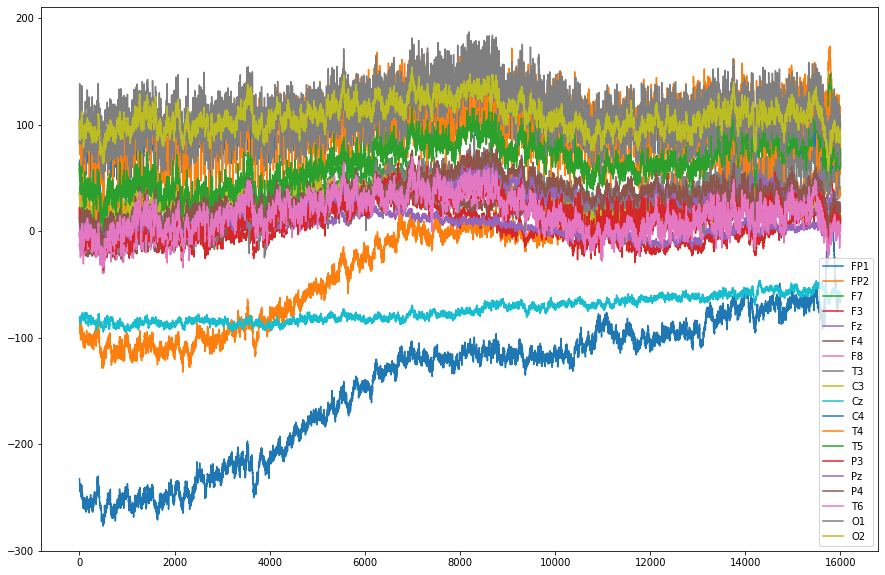

In [93]:
testdf.plot(figsize=(15, 10))

In [88]:
np.fft.rfftfreq(100,d=1/1000)

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
       440., 450., 460., 470., 480., 490., 500.])

Delta
Theta
Alpha
Beta
Gamma


Text(0, 0.5, 'Mean band Amplitude')

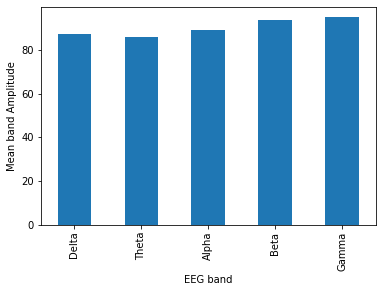

In [84]:
fs = 1000                             # Sampling rate (512 Hz)
# data = np.random.uniform(0, 100, 1024)  # 2 sec of data b/w 0.0-100.0

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(testdf[['Cz']]))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(testdf[['Cz']]), 1.0/fs)
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:  
    print(band)
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.max(fft_vals[freq_ix])

# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")

In [82]:
np.min(fft_vals),np.max(fft_vals)

(46.37241497238075, 95.02423038422803)

In [ ]:
def calc_bands_power(x, dt, bands):
    from scipy.signal import welch
    f, psd = welch(x, fs=1. / dt)
    power = {band: np.mean(psd[np.where((f >= lf) & (f <= hf))]) for band, (lf, hf) in bands.items()}
    return power


In [87]:
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}
for x in eeg_bands.items():
    print(x)        

('Delta', (0, 4))
('Theta', (4, 8))
('Alpha', (8, 12))
('Beta', (12, 30))
('Gamma', (30, 45))


In [46]:
testdf[['Cz', 'Cz_power']].groupby([testdf.index//10, 'Cz_power']).mean()

Cz
     Cz_power           
0    gamma    -82.368011
1    gamma    -85.263017
2    gamma    -84.275821
3    gamma    -83.295283
4    gamma    -80.187879
...                  ...
1595 gamma    -60.637711
1596 gamma    -59.394838
1597 gamma    -58.671308
1598 gamma    -60.400899
1599 gamma    -58.930536

[1600 rows x 1 columns]

<AxesSubplot:>

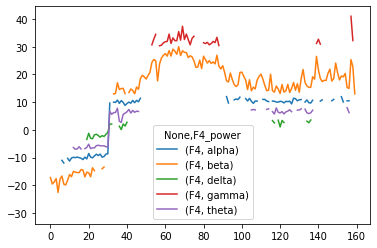

In [62]:
testdf[['F4', 'F4_power']].groupby([testdf.index//100,'F4_power',]).mean().unstack().plot()

apply a fourier transform to the data in discrete sections so that you can get the average levels of each 

# Feature Space Ideas: 
- descriptive statistics for important eeg nodes
- correlations between nodes
- alpha and theta levels? possibly beta?
- fast fourier
- dwt


In [24]:
train_data[0].columns

Index(['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
       'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'],
      dtype='object')

In [25]:
alph

NameError: name 'alph' is not defined

In [23]:
# Seperate target and non-target for plotting
tar     = train_data[np.where(pd.Series(train_labels).apply(binarizer).to_numpy() == 1)[0], :, :]
non_tar = train_data[np.where(pd.Series(train_labels).apply(binarizer).to_numpy() == 0)[0], :, :]

print('We have %d target trials' % tar.shape[0])
print('We have %d non-target trials' % non_tar.shape[0])

# We'll take the average of all trials to create an averaged ERP
tar_avg     = np.mean(tar, 0)
non_tar_avg = np.mean(non_tar, 0)

# Define channel of interest and create an array of time points
chan = 'Cz' # let's plot Cz
ch = np.where(channels == chan)[0][0]
times = np.linspace(epoch_start, epoch_end, train_data.shape[1])

# Initialize plot and calculate min and max y value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
min_y = min(np.min(tar_avg), np.min(non_tar_avg))
max_y = max(np.max(tar_avg), np.max(non_tar_avg))

# Plot x and y axes
plt.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
plt.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

# Plot our averaged ERPs
plt.plot(times, tar_avg[:, ch], 'b', linewidth=4)
plt.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

# Highlight the baseline window and window of interest of our ERP
baseline = patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
                             color='c', alpha=0.2)
erp_win = patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
                             color='lime', alpha=0.3)

# Add our baseline and window of interest highlights
ax.add_patch(baseline)
ax.add_patch(erp_win)

# Manually create legends since patches will corrupt default handles
legend_ = [patches.Patch(color='b', label = 'Target (oddball)'),
           patches.Patch(color='r', label = 'Non-target (standard)')]

# Finalize plot and set a high DPI for a crisp, hi-res figure
plt.xlabel('Time (msec)');
plt.ylabel('Amplitude (A/D Units)');
plt.legend(handles=legend_, loc="upper right");
plt.title('Event Related Potentials at channel %s' % chan);
fig.set_dpi(216);
plt.show();

TypeError: list indices must be integers or slices, not tuple

In [ ]:
# Let's compute the windowed means within erp_start and erp_end
num_points = 5; # we will divide our window into num_points means

# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    w = np.round((start+end)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials)) # assumes num chans as last dimension
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    return y

# Combine into a single train variable. Also create labels
X_train    = wm(train_data, erp_s, erp_e, num_points)
markers_train = np.vstack((train_labels, train_markers)).T
y = train_labels

# Now let's compute windowed means of our test data
X_test = wm(test_data, erp_s, erp_e, num_points)
markers_test = test_markers

# Let's print out the shapes of our data
print('X_train shape is: ' + str(X_train.shape))
print('y shape is......: ' + str(y.shape))
print('X_test shape is.: ' + str(X_test.shape))

In [ ]:
# Since our X is 3D, we must flatten our data. We will then transpose it for sklearn
X_train = X_train.reshape(-1, X_train.shape[-1]).T
X_test = X_test.reshape(-1, X_test.shape[-1]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(X_train.shape))
print('X_test  shape is now: ' + str(X_test.shape))

In [ ]:
# Train our classifier (this may take a while via JupyterHub)
clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto').fit(X_train, y)

In [ ]:
# Let's do 5-fold cross validation
score_lsqrs = cross_val_score(clf_lsqrs.fit(X_train, y), X_train, y, cv = 5)

# We will print out the mean score
print("solver = lsqr  accuracy: %f" % np.mean(score_lsqrs))